In [1]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 51kB/s 
     |████████████████████████████████| 3.1MB 32.9MB/s 
     |████████████████████████████████| 501kB 48.5MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [24]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-01-15 06:14:53--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.02s   

2020-01-15 06:14:53 (3.23 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



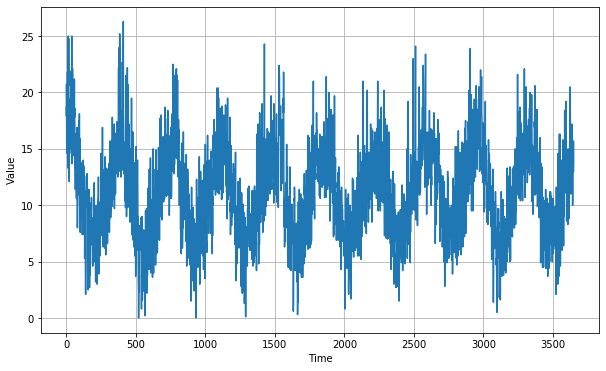

In [26]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
  reader= csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step +=1



series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [37]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal", activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences= True),
  tf.keras.layers.LSTM(64, return_sequences= True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 739ms/step - loss: 5.9832 - mae: 6.4775
Epoch 2/100
10/10 [==============================] - 5s 457ms/step - loss: 5.8410 - mae: 6.3365
Epoch 3/100
10/10 [==============================] - 5s 453ms/step - loss: 5.6285 - mae: 6.1245
Epoch 4/100
10/10 [==============================] - 5s 455ms/step - loss: 5.3779 - mae: 5.8734
Epoch 5/100
10/10 [==============================] - 5s 450ms/step - loss: 5.1016 - mae: 5.5960
Epoch 6/100
10/10 [==============================] - 5s 456ms/step - loss: 4.8059 - mae: 5.2992
Epoch 7/100
10/10 [==============================] - 5s 459ms/step - loss: 4.4979 - mae: 4.9897
Epoch 8/100
10/10 [==============================] - 5s 456ms/step - loss: 4.1911 - mae: 4.6807
Epoch 9/100
10/10 [==============================] - 5s 455ms/step - loss: 3.8999 - mae: 4.3868
Epoch 10/100
10/10 [==============

[1e-08, 0.0001, 0, 10]

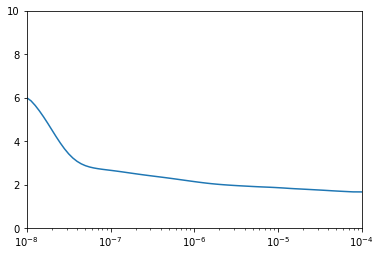

In [39]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 10])

In [40]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences= True),
  tf.keras.layers.LSTM(64, return_sequences= True),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100)
])


optimizer = tf.keras.optimizers.SGD(lr= 1e-4, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs= 150) # YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 9s 341ms/step - loss: 3.2357 - mae: 3.7242
Epoch 2/150
25/25 [==============================] - 5s 220ms/step - loss: 1.9514 - mae: 2.4082
Epoch 3/150
25/25 [==============================] - 5s 219ms/step - loss: 1.7723 - mae: 2.2232
Epoch 4/150
25/25 [==============================] - 5s 219ms/step - loss: 1.7239 - mae: 2.1733
Epoch 5/150
25/25 [==============================] - 5s 218ms/step - loss: 1.6951 - mae: 2.1438
Epoch 6/150
25/25 [==============================] - 5s 220ms/step - loss: 1.6704 - mae: 2.1189
Epoch 7/150
25/25 [==============================] - 6s 220ms/step - loss: 1.6511 - mae: 2.0993
Epoch 8/150
25/25 [==============================] - 5s 218ms/step - loss: 1.6335 - mae: 2.0810
Epoch 9/150
25/25 [==============================] - 5s 219ms/step - loss: 1.6212 - mae: 2.0677
Epoch 10/150
25/25 [==============================] - 5s 217ms/step - loss: 1.6054 - mae: 2.0505
Epoch 11/150
25/25 [===================

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

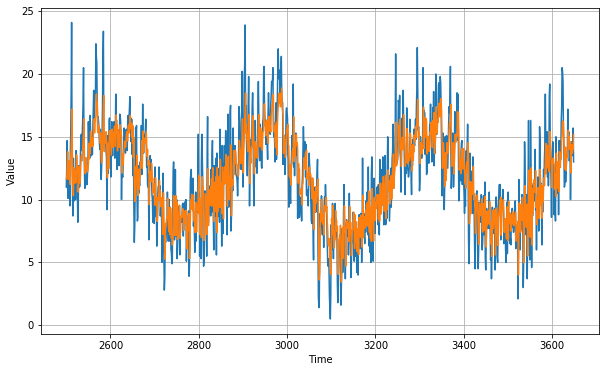

In [42]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [43]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7729552

In [44]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.646536 11.638047 12.780079 ... 13.873978 13.991112 15.188368]
